In [0]:
# Loading script for gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = '/content/gdrive/My Drive/NLP Assignment 3'

In [0]:
#dont run again
!pip install flair

In [0]:
#Libraries
from flair.embeddings import BertEmbeddings
from flair.data import Sentence
import numpy as np
import string

In [0]:
def fp_to_list(fp):
	all_words_withoutpp=[]
	for line in fp:
		line = line.strip()
		all_words_withoutpp.append(line)
	return all_words_withoutpp

In [0]:
all_hin_words = []
for sample in all_words_withoutpp:
  if sample[-3:] == 'Hin':
    all_hin_words.append(sample[:-4])


In [0]:
others = []
for word in all_words_withoutpp:
  try:
    if word[-1] == "O":
      others.append(word[:-2])
  except:
    continue
others = set(others)

In [0]:
# Remove punctuation
def rem_punc(all_words_withoutpp):
  allwords_nopunc = all_words_withoutpp.copy()
  punc = list(string.punctuation)
  punc.remove("@") #remove tags separately; not removing hashtags because they also have sentiment
  index = []

  for i, word in enumerate(allwords_nopunc):
    if word == "":
      del allwords_nopunc[i]
    elif word[-1] == "O":
      if word[:-2] in punc:
        del allwords_nopunc[i]
  
  return allwords_nopunc


In [0]:
# Remove tags and URLs
def rem_tags_urls(allwords_nopunc):

  allwords_pp = allwords_nopunc.copy()

  for i, word in enumerate(allwords_pp):
    if word[:-2] == "@":
      del allwords_pp[i]
      del allwords_pp[i+1]  #this will be the username following the hashtag
      i+=1
    elif word[:-4] == "https":
      del allwords_pp[i]
      del allwords_pp[i+1]
      del allwords_pp[i+2]
      del allwords_pp[i+3]
      del allwords_pp[i+4]
      i=i+4
    elif word[:-4] == '//':
      del allwords_pp[i]
    elif word[:-4] == 'co':
      del allwords_pp[i]
    elif word[-3:] == 'EMT':
      del allwords_pp[i]

  return allwords_pp




In [0]:
# Remove all words of type other - contain numbers and emojis 
def rem_useless(allwords_pp):
  a = allwords_pp.copy()
  for i, word in enumerate(a):
    if word == "":
      del a[i] 
    elif word[-1] == "O":
      del a[i]

  return a

In [0]:
len(allwords_pp), len(allwords_nopunc), len(all_words_withoutpp)

(288188, 382702, 426280)

In [0]:
emb_bert = BertEmbeddings("bert-base-multilingual-cased")

100%|██████████| 714314041/714314041 [00:17<00:00, 39803991.21B/s]


In [0]:
def make_dict(allwords_pp):
  tweets = dict()
  for elem in allwords_pp:
    if (elem[:5] == 'meta\t'):
      key = elem
      tweets[key] = []
    else:
      tweets[key].append(elem.split('\t'))
  return tweets



In [0]:
def make_bert_emb(tweets):
  embeddings = []
  for key in tweets.keys():
    sentence = Sentence((" ").join(word[0][:-4] for word in tweets[key]))
    embeddings.append(emb_bert.embed(sentence)) #this only divides sentence into tokens
  embeddings_bert = []
  for x, sent in enumerate(embeddings):
    temp=[]
    for t in sent[0]:
      temp.append(np.array(t.embedding.cpu()))
    embeddings_bert.append(np.array(temp))
  return embeddings_bert


In [0]:
fp_train = open("/content/gdrive/My Drive/NLP Assignment 3/train.txt", 'r')
fp_test = open("/content/gdrive/My Drive/NLP Assignment 3/test.txt", 'r')

In [0]:

# make and save bert embeddings for training data
train_withoutpp = fp_to_list(fp_train)
train_remove_punc = rem_punc(train_withoutpp)
train_notagsurls = rem_tags_urls(train_remove_punc)
train_pp = rem_useless(train_notagsurls)
train_tweets = make_dict(train_pp)


In [0]:
# make and save bert embeddings for training data
test_withoutpp = fp_to_list(fp_test)
test_remove_punc = rem_punc(test_withoutpp)
test_notagsurls = rem_tags_urls(test_remove_punc)
test_pp = rem_useless(test_notagsurls)
test_tweets = make_dict(test_pp)


In [0]:
train_embs = make_bert_emb(train_tweets)
np.save("/content/gdrive/My Drive/NLP Assignment 3/train_emb_bert.npy", np.array(train_emb_bert))

test_embs = make_bert_emb(test_tweets)
np.save("/content/gdrive/My Drive/NLP Assignment 3/test_emb_bert.npy", np.array(test_emb_bert))

2019-11-17 08:32:42,422 ACHTUNG: An empty Sentence was created! Are there empty strings in your dataset?
2019-11-17 08:34:25,943 ACHTUNG: An empty Sentence was created! Are there empty strings in your dataset?
2019-11-17 08:35:09,448 ACHTUNG: An empty Sentence was created! Are there empty strings in your dataset?
2019-11-17 08:35:40,892 ACHTUNG: An empty Sentence was created! Are there empty strings in your dataset?
2019-11-17 08:36:02,411 ACHTUNG: An empty Sentence was created! Are there empty strings in your dataset?


In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')

y_train = []

sentiment_to_no = {"ositive":1, "neutral": 0, "egative":-1}

for key in train_tweets:
  y_train.append(sentiment_to_no[key[-7:]])
y_tr = np.array(y_train)
enc.fit(y_tr.reshape(-1,1))
y_train = enc.transform(y_tr.reshape(-1,1)).toarray()


y_test = []

for key in test_tweets:
  y_test.append(sentiment_to_no[key[-7:]])
y_ts = np.array(y_test)
enc.fit(y_ts.reshape(-1,1))
y_test = enc.transform(y_ts.reshape(-1,1)).toarray()


In [0]:
from torch.nn.utils.rnn import pad_sequence
import torch

In [0]:
len(train_embs), len(y_train)

(15131, 15131)

In [0]:
#make all inputs of same size for the neural model
X_train = train_embs
X_test = test_embs
e = []
for emb in X_train:
  e.append(torch.tensor(emb[:30]).cuda())
X_train = pad_sequence(e, batch_first=True)

e = []
for emb in X_test:
  e.append(torch.tensor(emb[:30]).cuda())
X_test = pad_sequence(e, batch_first=True)

In [0]:
!pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=219cc0d052a5f179937b3eacbe00a967f5302c939fac55b7ca6512827c50f7a4
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Bidirectional
from keras import optimizers
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import concatenate
import keras
from IPython.display import SVG
from keras_self_attention import SeqSelfAttention
from keras.utils import plot_model
from sklearn.metrics import classification_report


In [0]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True), input_shape=(30, 3072), merge_mode='concat'))
model1.add(SeqSelfAttention(attention_activation='relu'))
model1.add(GRU(8, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))

model1.add(Dense(5, activation='softmax'))
model1.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 30, 64)            794880    
_________________________________________________________________
seq_self_attention_5 (SeqSel (None, 30, 64)            4161      
_________________________________________________________________
gru_5 (GRU)                  (None, 8)                 1752      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 18        
Total params: 800,856
Trainable params: 800,856
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.fit(x=X_train.cpu().numpy(), y=y_train, validation_data=(X_test.cpu().numpy(), y_test),	batch_size=16, epochs=23, shuffle=True)

Train on 15131 samples, validate on 1869 samples
Epoch 1/23
15131/15131 [==============================] - 114s 8ms/step - loss: 0.8002 - categorical_accuracy: 0.6292 - val_loss: 0.9694 - val_categorical_accuracy: 0.5554
Epoch 2/23
15131/15131 [==============================] - 113s 7ms/step - loss: 0.7986 - categorical_accuracy: 0.6277 - val_loss: 0.9633 - val_categorical_accuracy: 0.5559
Epoch 3/23
15131/15131 [==============================] - 114s 8ms/step - loss: 0.7982 - categorical_accuracy: 0.6275 - val_loss: 0.9767 - val_categorical_accuracy: 0.5554
Epoch 4/23
15131/15131 [==============================] - 113s 7ms/step - loss: 0.7992 - categorical_accuracy: 0.6279 - val_loss: 0.9604 - val_categorical_accuracy: 0.5548
Epoch 5/23
15131/15131 [==============================] - 113s 7ms/step - loss: 0.8029 - categorical_accuracy: 0.6245 - val_loss: 0.9949 - val_categorical_accuracy: 0.5329
Epoch 6/23
15131/15131 [==============================] - 118s 8ms/step - loss: 0.7942 - ca

In [0]:
model1.evaluate(X_test.cpu().numpy(),y_test)

1869/1869 [==============================] - 4s 2ms/step


[0.9846205725396873, 0.5634028894050419]

In [0]:
y_pred = model1.predict_classes(X_test.cpu().numpy(), batch_size=16,verbose=0)

In [0]:
y_enc = {0:[1, 0, 0], 1:[0, 1, 0], 2:[0, 0, 1]}

y_pred_enc = np.array([y_enc[i] for i in y_pred])

In [0]:
print(classification_report(y_test, y_pred_enc, target_names=['Positive', 'Neutral', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.63      0.41      0.49       533
     Neutral       0.52      0.64      0.57       754
    Negative       0.60      0.60      0.60       582

   micro avg       0.56      0.56      0.56      1869
   macro avg       0.58      0.55      0.56      1869
weighted avg       0.57      0.56      0.56      1869
 samples avg       0.56      0.56      0.56      1869



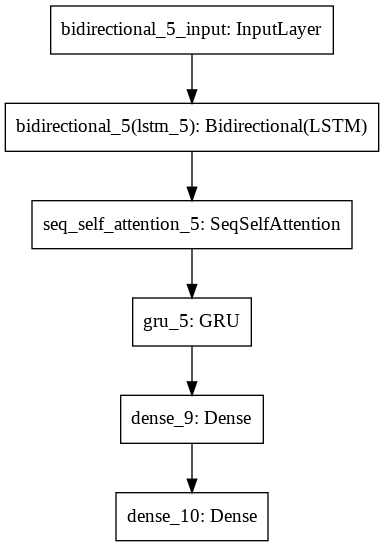

In [0]:
plot_model(model1, to_file="model.png")